In [316]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from scipy.optimize import differential_evolution

from warnings import simplefilter, filterwarnings
filterwarnings("ignore", category=FutureWarning)
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
simplefilter(action="ignore", category=pd.errors.SettingWithCopyWarning)

In [252]:
patients = ['001', '002', '004', '006', '007', '008']
features = ['simple_sugars', 'complex_sugars', 'fats', 'dietary_fibers', 'proteins', 'fast_insulin', 'slow_insulin']

In [253]:
def get_projected_value(window, prediction_horizon):
    x = np.arange(len(window))
    coeffs = np.polyfit(x, window, deg=3)
    poly = np.poly1d(coeffs)
    projected_value = poly(len(window) + prediction_horizon)
    return projected_value


def get_data(patient, food_data, prediction_horizon):
    glucose_data = pd.read_csv(f"diabetes_subset_pictures-glucose-food-insulin/{patient}/glucose.csv")
    insulin_data = pd.read_csv(f"diabetes_subset_pictures-glucose-food-insulin/{patient}/insulin.csv")

    glucose_data["datetime"] = pd.to_datetime(glucose_data["date"] + ' ' + glucose_data["time"])
    glucose_data.drop(['type', 'comments', 'date', 'time'], axis=1, inplace=True)
    glucose_data['glucose'] *= 18.0182  # Convert to mg/dL

    insulin_data["datetime"] = pd.to_datetime(insulin_data["date"] + ' ' + insulin_data["time"])
    insulin_data.drop(['comment', 'date', 'time'], axis=1, inplace=True)

    food_data['datetime'] = pd.to_datetime(food_data['datetime'], format='%Y:%m:%d %H:%M:%S')
    food_data = food_data[['datetime', 'simple_sugars', 'complex_sugars', 'proteins', 'fats', 'dietary_fibers']]

    combined_data = pd.concat([food_data, insulin_data]).sort_values('datetime').reset_index(drop=True)
    combined_data.fillna(0, inplace=True)
    glucose_data['hour'] = glucose_data['datetime'].dt.hour

    glucose_data['glucose_next'] = glucose_data['glucose'] - glucose_data['glucose'].shift(-prediction_horizon)

    glucose_data['glucose_change'] = glucose_data['glucose'] - glucose_data['glucose'].shift(1)

    glucose_data[f'glucose_change_sh_3'] = glucose_data['glucose_change'].shift(3)

    for window in [2, 3, 6]:
        glucose_data[f'glucose_change_std_{window}'] = glucose_data['glucose_change'].rolling(window=window).std()
    
    delta = glucose_data['glucose'].diff(1)
    gain = delta.where(delta > 0, 0).rolling(window=6).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=6).mean()
    glucose_data['glucose_rsi'] = 100 - (100 / (1 + gain / loss))

    glucose_data['glucose_change_projected'] = glucose_data['glucose_change'].rolling(
        window=6, min_periods=6
    ).apply(lambda window: get_projected_value(window, prediction_horizon))
    glucose_data['glucose_projected'] = glucose_data['glucose'].rolling(
        window=6, min_periods=6
    ).apply(lambda window: get_projected_value(window, prediction_horizon))
    glucose_data.dropna(subset=['glucose_next'], inplace=True)
    return glucose_data, combined_data

def calculate_weights(time_diff_hours, metabolism_rate, peak_time):
    weights = np.zeros_like(time_diff_hours)
    increase_mask = (time_diff_hours >= 0) & (time_diff_hours < peak_time)
    plateau_duration = 0.25
    weights[increase_mask] = time_diff_hours[increase_mask] / peak_time
    plateau_mask = (time_diff_hours >= peak_time) & (time_diff_hours < peak_time + plateau_duration)
    weights[plateau_mask] = 1
    decrease_mask = time_diff_hours >= peak_time + plateau_duration
    weights[decrease_mask] = 1 - ((time_diff_hours[decrease_mask] - peak_time - plateau_duration) * metabolism_rate)
    return np.clip(weights, 0, None)


def add_features(params, features, preprocessed_data, prediction_horizon):
    glucose_data, combined_data = preprocessed_data
    
    glucose_times = glucose_data['datetime'].values.astype('datetime64[s]').astype(np.int64)
    combined_times = combined_data['datetime'].values.astype('datetime64[s]').astype(np.int64)
    for feature in features:
        metabolism_rate, peak_time = params[feature]
        time_diff_hours = ((glucose_times[:, None] - combined_times[None, :]) / 3600)
        weights = np.zeros_like(time_diff_hours)
        increase_mask = (time_diff_hours >= 0) & (time_diff_hours < peak_time)
        weights[increase_mask] = time_diff_hours[increase_mask] / peak_time
        plateau_duration = 0.25
        plateau_mask = (time_diff_hours >= peak_time) & (time_diff_hours < peak_time + plateau_duration)
        weights[plateau_mask] = 1
        decrease_mask = time_diff_hours >= peak_time + plateau_duration
        weights[decrease_mask] = 1 - ((time_diff_hours[decrease_mask] - peak_time - plateau_duration) * metabolism_rate)
        weights = np.clip(weights, 0, None)
        glucose_data[feature] = np.dot(weights, combined_data.loc[:, feature].values)
        glucose_data[feature] = glucose_data[feature] - glucose_data[feature].shift(-prediction_horizon) + glucose_data['glucose_change']
    glucose_data.dropna(inplace=True)
    return glucose_data

In [254]:
approach = 'gpt4o'
prediction_horizon = 6
patient = '001'
food_data = pd.read_csv(f"food_data/{approach}/{patient}.csv")
features_to_remove = ['glucose_next', 'datetime']
feature_params = {
    'simple_sugars': [0.5, 0.5],  # [insulin_sensitivity_param, peak_time]
    'complex_sugars': [0.3, 0.5],
    'proteins': [0.2, 3.5],
    'fats': [0.05, 3.5], 
    'dietary_fibers': [0.05, 3.5],
    'fast_insulin': [1.0, 0.5], 
    'slow_insulin': [0.5, 1.0]
}

In [256]:
def modify_macronutrients(food_data, nutrient, amount):
    """Modify a specific macronutrient by a given amount."""
    modified_food_data = food_data.copy()
    modified_food_data[nutrient] += amount
    # Ensure values remain non-negative
    modified_food_data[nutrient] = modified_food_data[nutrient].clip(lower=0)
    return modified_food_data

In [258]:
# Create DataFrame to store results
results_df = pd.DataFrame(columns=['feature', 'increment', 'hyper_minutes', 'hypo_minutes', 'mean_glucose'])
meal_features = ['simple_sugars', 'complex_sugars', 'fats', 'dietary_fibers', 'proteins']
increments = [-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50] 
# Simulate additions/subtractions for each feature
for feature in meal_features:
    for increment in increments:
        patient_hyper_times = []
        patient_hypo_times = []
        patient_means = []
        for patient in patients:
            # Load patient model
            model = joblib.load(f'models/{approach}/6_1_{patient}.joblib')

            # Get modified predictions
            modified_food_data = modify_macronutrients(food_data, feature, increment)
            data_modified = get_data(patient, modified_food_data, prediction_horizon)
            test_modified = add_features(feature_params, features, data_modified, prediction_horizon)
            X_test_modified = test_modified.drop(features_to_remove, axis=1)
            preds_modified = X_test_modified['glucose'] - model.predict(X_test_modified)

            # Convert predictions to binary indicators and calculate time in minutes
            hyper_binary_preds = (preds_modified >= 180).astype(int)
            hypo_binary_preds = (preds_modified <= 70).astype(int)
            
            hyperglycemia_count = np.sum(hyper_binary_preds)
            hypoglycemia_count = np.sum(hypo_binary_preds)
            
            hyperglycemia_hours = hyperglycemia_count / 12
            hypoglycemia_hours = hypoglycemia_count / 12
            
            patient_hyper_times.append(hyperglycemia_hours)
            patient_hypo_times.append(hypoglycemia_hours)
            patient_means.append(np.mean(preds_modified))

            # Average time and glucose levels across patients
            total_hyper_time = np.mean(patient_hyper_times)
            total_hypo_time = np.mean(patient_hypo_times)
            mean_glucose = np.mean(patient_means)

            # Store in DataFrame
            results_df = pd.concat([results_df, pd.DataFrame({
                'feature': [feature],
                'increment': [increment],
                'hyper_minutes': [total_hyper_time],
                'hypo_minutes': [total_hypo_time],
                'mean_glucose': [mean_glucose]
            })])

# Pivot the DataFrame for easier calculations
hyper_pivot_df = results_df.pivot_table(index='increment', columns='feature', values='hyper_minutes', aggfunc='mean')
hypo_pivot_df = results_df.pivot_table(index='increment', columns='feature', values='hypo_minutes', aggfunc='mean')
glucose_pivot_df = results_df.pivot_table(index='increment', columns='feature', values='mean_glucose', aggfunc='mean')

# Get the baseline values at increment = 0
hyper_baseline = hyper_pivot_df.loc[0]
hypo_baseline = hypo_pivot_df.loc[0]
glucose_baseline = glucose_pivot_df.loc[0]

# Calculate the difference from the baseline
hyper_difference_df = hyper_pivot_df.subtract(hyper_baseline, axis='columns').reset_index()
hypo_difference_df = hypo_pivot_df.subtract(hypo_baseline, axis='columns').reset_index()
glucose_difference_df = glucose_pivot_df.subtract(glucose_baseline, axis='columns').reset_index()

In [321]:
glucose_difference_df

feature,increment,complex_sugars,dietary_fibers,fats,proteins,simple_sugars
0,-50,-0.596923,0.126037,0.063190,-0.049013,-0.483230
1,-40,-0.575732,0.126037,0.063190,-0.049013,-0.465254
2,-30,-0.508508,0.126037,0.063190,-0.049013,-0.426984
3,-20,-0.378627,0.126037,0.052445,-0.013331,-0.344004
4,-10,-0.216140,0.110379,0.030807,-0.012253,-0.223728
5,0,0.000000,0.000000,0.000000,0.000000,0.000000
6,10,0.253247,-0.369735,-0.165155,-0.145384,0.187955
7,20,0.548710,-0.844542,-0.516403,-0.359719,0.218963
8,30,0.853746,-1.220336,-1.111571,-0.694514,0.168596
9,40,1.087354,-1.283659,-1.878541,-1.127191,0.151685


In [260]:
hyper_difference_df

feature,increment,complex_sugars,dietary_fibers,fats,proteins,simple_sugars
0,-50,-0.214815,-0.042361,-0.125000,-0.048843,-0.339815
1,-40,-0.214815,-0.042361,-0.125000,-0.048843,-0.339815
2,-30,-0.138889,-0.042361,-0.125000,-0.048843,-0.319676
3,-20,-0.113426,-0.042361,-0.125000,-0.048843,-0.317361
4,-10,-0.043519,-0.042361,-0.111111,-0.008565,-0.201389
5,0,0.000000,0.000000,0.000000,0.000000,0.000000
6,10,0.042593,-0.073380,-0.069444,-0.144444,0.030556
7,20,0.140972,-0.186806,-0.237037,-0.447454,0.065509
8,30,0.153009,-0.140278,-0.367361,-0.496759,0.010648
9,40,0.176852,-0.167824,-0.298148,-0.883102,0.053241


In [261]:
hypo_difference_df

feature,increment,complex_sugars,dietary_fibers,fats,proteins,simple_sugars
0,-50,0.183333,-0.063657,-0.006250,0.046528,0.322685
1,-40,0.183333,-0.063657,-0.006250,0.046528,0.356713
2,-30,0.136111,-0.063657,-0.006250,0.046528,0.314120
3,-20,0.068056,-0.063657,-0.006250,0.013194,0.157870
4,-10,-0.013194,-0.063657,-0.006250,0.000000,0.068056
5,0,0.000000,0.000000,0.000000,0.000000,0.000000
6,10,-0.089120,0.161343,0.092361,0.000000,-0.158565
7,20,-0.089120,0.582176,0.253241,0.000000,-0.228935
8,30,-0.223843,0.868519,0.463889,0.030787,-0.169676
9,40,-0.246296,1.168519,0.905556,0.037269,-0.169676


In [322]:
results_df.loc[(results_df['feature'] == 'fats') & (results_df['increment'] == 50), 'mean_glucose'] - glucose_baseline.values[0]

0    -2.886480
0     2.811523
0     4.650915
0     0.296342
0    -6.001883
0   -13.389951
Name: mean_glucose, dtype: float64

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


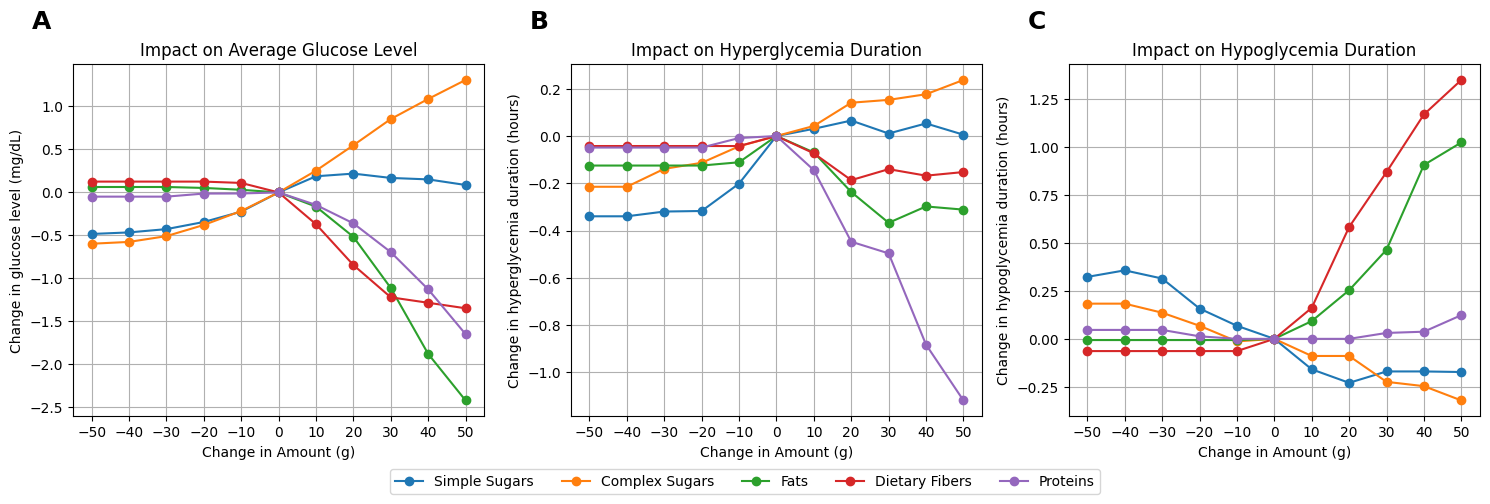

In [320]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Add bold A, B and C labels
ax1.text(-0.1, 1.1, 'A', transform=ax1.transAxes, fontsize=18, fontweight='bold')
ax2.text(-0.1, 1.1, 'B', transform=ax2.transAxes, fontsize=18, fontweight='bold')
ax3.text(-0.1, 1.1, 'C', transform=ax3.transAxes, fontsize=18, fontweight='bold')

# Plot mean glucose changes
for feature in meal_features:
    ax1.plot(
        glucose_difference_df['increment'],
        glucose_difference_df[feature],
        'o-',
        label=feature.replace('_', ' ').title()
    )

ax1.set_xlabel('Change in Amount (g)')
ax1.set_ylabel('Change in glucose level (mg/dL)')
ax1.set_title('Impact on Average Glucose Level')
ax1.grid(True)
ax1.set_xticks(increments)

# Plot hyperglycemia
for feature in meal_features:
    ax2.plot(
        hyper_difference_df['increment'],
        hyper_difference_df[feature],
        'o-',
        label=feature.replace('_', ' ').title()
    )

ax2.set_xlabel('Change in Amount (g)')
ax2.set_ylabel('Change in hyperglycemia duration (hours)')
ax2.set_title('Impact on Hyperglycemia Duration')
ax2.grid(True)
ax2.set_xticks(increments)

# Plot hypoglycemia
for feature in meal_features:
    ax3.plot(
        hypo_difference_df['increment'],
        hypo_difference_df[feature],
        'o-',
        label=feature.replace('_', ' ').title()
    )

ax3.set_xlabel('Change in Amount (g)')
ax3.set_ylabel('Change in hypoglycemia duration (hours)')
ax3.set_title('Impact on Hypoglycemia Duration')
ax3.grid(True)
ax3.set_xticks(increments)



# Add single legend at the bottom
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, 0.02), ncol=len(meal_features))

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)

plt.savefig('paper_images/nutrient_glycemia_difference.eps', format='eps')
plt.show()

## Glucovision

In [264]:
def modify_macronutrients(food_data, nutrient, amount, meal_time):
    modified_food_data = food_data.copy()
    # Find the meal closest to the specified meal_time
    time_diffs = abs(modified_food_data['datetime'] - meal_time)
    meal_index = time_diffs.idxmin()
    # Modify the nutrient for that meal
    modified_food_data.loc[meal_index, nutrient] += amount
    # Ensure values remain non-negative
    modified_food_data[nutrient] = modified_food_data[nutrient].clip(lower=0)
    return modified_food_data

In [382]:
patient = '004'
selected_img = '006.jpg'
food_data = pd.read_csv(f"food_data/{approach}/{patient}.csv")
# Initialize variables to track the best combination
food_data['datetime'] = pd.to_datetime(food_data['datetime'], format='%Y:%m:%d %H:%M:%S')
meal_time = food_data.loc[food_data['picture'] == selected_img, 'datetime'].values[0]

meal_features = ['simple_sugars', 'complex_sugars', 'fats', 'dietary_fibers', 'proteins']
increments = [-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50]

# Load model once instead of in the loop
model = joblib.load(f'models/{approach}/6_1_{patient}.joblib')

# Get baseline prediction
data_baseline = get_data(patient, food_data, prediction_horizon)
test_baseline = add_features(feature_params, features, data_baseline, prediction_horizon)

# Get timestamps within 30 minutes after meal
time_diffs = test_baseline['datetime'] - meal_time
valid_times = (time_diffs >= pd.Timedelta(minutes=0)) & (time_diffs <= pd.Timedelta(minutes=30))
test = pd.DataFrame(test_baseline[valid_times].iloc[-1]).T

# Convert all columns to numeric before prediction
numeric_cols = test.select_dtypes(include=['object']).columns
for col in numeric_cols:
    test[col] = pd.to_numeric(test[col], errors='coerce')

X_test = test.drop(features_to_remove, axis=1)
preds_baseline = test['glucose'].values[0] - model.predict(X_test)
actual_glucose = (X_test['glucose'] - test['glucose_next']).values[0]
print(f"Baseline predicted glucose: {preds_baseline[0]:.2f} mg/dL")
print(f"Baseline actual glucose: {actual_glucose:.2f} mg/dL")
print(f'Current glucose: {test["glucose"].values[0]:.2f} mg/dL')

Baseline predicted glucose: 310.70 mg/dL
Baseline actual glucose: 327.93 mg/dL
Current glucose: 239.64 mg/dL


327.93124

In [383]:
food_data.loc[food_data['picture'] == selected_img, meal_features]

,simple_sugars,complex_sugars,fats,dietary_fibers,proteins
5,5,55,25,3,20


In [373]:
# Generate all possible combinations of increments for meal features
meal_features = ['simple_sugars', 'complex_sugars', 'fats', 'dietary_fibers', 'proteins']
increments = [-50, 0, 50]
combinations = list(itertools.product(increments, repeat=len(meal_features)))

# Initialize a list to store all modified test samples and corresponding modifications
modified_samples = pd.DataFrame()
modification_dicts = []

# Loop over all combinations to create modified test samples
for combo in combinations:
    # Create a copy of the original food data
    modified_food_data = food_data.copy()
    
    # Create modifications dict
    modifications = dict(zip(meal_features, combo))
    
    # Find the meal index (assuming we're modifying a specific meal time)
    time_diffs = abs(modified_food_data['datetime'] - meal_time)
    meal_index = time_diffs.idxmin()
    
    # Apply the modifications to the meal
    for nutrient, amount in modifications.items():
        modified_value = modified_food_data.loc[meal_index, nutrient] + amount
        modified_food_data.loc[meal_index, nutrient] = max(0, modified_value)
    
        # Process the modified data
        data_modified = get_data(patient, modified_food_data, prediction_horizon)
        test_modified = add_features(feature_params, features, data_modified, prediction_horizon)
        
        # Select the test sample (assuming we're interested in the last row)
        test_sample = pd.DataFrame(test_modified[valid_times].iloc[-1]).T
        
        # Append the test sample and modifications to the lists
        modified_samples = pd.concat([modified_samples, test_sample])
        modification_dicts.append(modifications)

# Prepare the data for prediction
X_test = modified_samples.drop(features_to_remove, axis=1)

# Ensure all columns are numeric
X_test = X_test.apply(pd.to_numeric, errors='coerce')

# Use the model to predict all samples at once
predictions = X_test['glucose'] - model.predict(X_test)
print(f'Lowest predicted glucose: {np.min(predictions)}')
best_idx = np.argmin(predictions)
best_modification = modification_dicts[best_idx]
print(f'Best modification: {best_modification}')


Lowest predicted glucose: 287.19589763825
Best modification: {'simple_sugars': -50, 'complex_sugars': 0, 'fats': 50, 'dietary_fibers': 50, 'proteins': -50}


In [390]:
original_values = food_data.loc[food_data['picture'] == selected_img, meal_features].values[0]
modified_values = original_values.copy()
for i, feature in enumerate(meal_features):
    modified_values[i] = max(0, modified_values[i] + best_modification[feature])

# Calculate changes between original and modified values
changes = modified_values - original_values

print(f'Original values: {original_values}')
print(f'Modified values: {modified_values}') 
print(f'Changes: {changes}')

Original values: [ 5 55 25  3 20]
Modified values: [ 0 55 75 53  0]
Changes: [ -5   0  50  50 -20]


In [398]:
meal_modification_changes = f'{changes[0]}g simple sugars, {changes[1]}g complex sugars, {changes[2]}g fats, {changes[3]}g dietary fibers, {changes[4]}g proteins'

In [393]:
import requests
import base64

api_key = "sk-WOih6ZqdppfFCsptpJcFsSpWJ8u-9Cuy_-6N-inqcST3BlbkFJnff9SwAVU-YXkjDVdoOA1p9LAgfhqzhgsTRWZimmQA"
headers = {
  "Content-Type": "application/json",
  "Authorization": f"Bearer {api_key}"
}

def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

def openai_api_call(base64_image, llm_instructions):
    payload = {
    "model": "gpt-4o",
    "messages": [
        {
        "role": "user",
        "content": [
            {
            "type": "text",
            "text": llm_instructions
            },
            {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{base64_image}"
            }
            }
        ]
        }
    ],
    "max_tokens": 300
    }
    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
    message = response.json()['choices'][0]['message']['content']
    return message

In [402]:
llm_instructions = f"""Come up with adequate meal modifications given the shown meal and the following recommendations: 
{meal_modification_changes}
- ..."""

In [403]:
base64_image = encode_image('diabetes_subset_pictures-glucose-food-insulin/004/food_pictures/006.jpg')
message = openai_api_call(base64_image, llm_instructions)
print(message)

To modify the meal based on the given nutritional recommendations, consider the following changes:

1. **Reduce Protein Content:**
   - Remove some of the cheese or meat toppings from the pizza, as they are significant sources of protein.

2. **Increase Fat:**
   - Add toppings rich in healthy fats, such as avocados or seeds like sunflower or pumpkin seeds.
   - Consider drizzling olive oil on top of the pizza for added fat content.

3. **Increase Dietary Fiber:**
   - Add a side salad with leafy greens, beans, or lentils to increase the fiber content.
   - Consider incorporating vegetables with high fiber content (such as broccoli or spinach) as additional toppings.

4. **Limit Simple Sugars:**
   - Avoid sugary drinks or desserts with this meal.

5. **Ensure No Complex Sugars:**
   - The pizza dough contains complex carbohydrates. While the recommendation is 0g complex sugars, replacing it with a cauliflower crust could help reduce carbohydrate intake.

By making these changes, you c